# Balancer Functions Commentary

## Intro:
We have a model of stable swap invariant AMM based on math, provided from Balancer Github (StableMath.sol)

## Task:
This document is a little research on what happens if spot prices in the market and in the pool are dsignificantly different.

## Solution:
A model of arbitrageur was written to simulate simple arbitrage trading step for provided prices and balances in a pool

In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as opt
import csv
import math
import random
import pandas as pd
import copy
ONE = int(1e18)
AMP_PRECISION = int(1e3)

## Pool functions source code:

#### Note!

    Functions followed with _b represent fixed point math operations and currently do not work properly.
    However, this is not crucial as we operate with stable tokens that have price close to 1 USD.
    Thus floating point operations error is negligeble.
    In future updates, proper fixed point operations would be added.

In [5]:
#pool functions
def calculateInvariant_b(A, pool, roundUp):
    n = len(pool)
    S = 0
    for i in range(0, n):
        if (not(isinstance(pool[i], int))):
            raise TypeError('Not int in pool')
        S = S + pool[i]
    prevD = 0
    D = S
    An = mul(A, pow(n, n))
    for i in range(0, 255):
        P_D = pool[0]*n
        for j in range (1, n):
                P_D = div(mul(mul(P_D, pool[j]), n), D, roundUp)
        prevD = D
        D = div(
            add(mul(mul(n, D), D), mul(mul(An, S), P_D)
            ),
            add(mul(n + 1, D), mul(An - 1, P_D)
            ),
            roundUp
            )
        if (D > prevD):
            if (D - prevD <= 1):
                return D
        elif (prevD - D <= 1):
            return D

    raise NoConvergenceException('D didn\'t converge, error = ', abs(D - prevD))
    
def calculateInvariant(A, pool):
    n = len(pool)
    S = sum(pool)
    P = 1
    for i in range(0, n):
        P = P*pool[i]
    t = pow(n, n)
    D = S
    T = A*t
    
    for i in range(0, 255):
        prevD = D
        K = pow(D, n)/(t*P)
        D = (n*K*D + T*S)/(T + (n+1)*K - 1)
        if (D > prevD):
            if (D - prevD <= 1):
                return D
        elif (prevD - D <= 1):
            return D
    raise NoConvergenceException('D didn\'t converge')
        


def getTokenBalanceGivenInvariantAndAllOtherBalances_b(A, pool, D, tokenindex):
    n = len(pool)
    S = pool[0]
    P_D = pool[0]*n
    for j in range(1, n):
        P_D = divDown(mul(mul(P_D, pool[j]), n), D)
        S = add(S, pool[j])
    S = sub(S, pool[tokenindex])
    D2 = mul(D, D)
    An = int(A*pow(n, n))
    
    c = mul(
        divUp(D2, mul(An, P_D)),
        pool[tokenindex]
    )
    
    b = add(S,divDown(D, An))
    
    prevTokenBalance = 0
    
    tokenBalance = divUp(add(D2, c), add(D, b))
    
    
    for i in range(0, 255):
        prevTokenBalance = tokenBalance
        
        tokenBalance = divUp(
            add(mul(tokenBalance, tokenBalance), c),
            sub(add(mul(tokenBalance, 2), b), D)
        )
        if (tokenBalance > prevTokenBalance):
            if (tokenBalance - prevTokenBalance <= 1000):
                return tokenBalance
        elif (prevTokenBalance - tokenBalance <= 1000):
            return tokenBalance
        
    raise NoConvergenceException('balance didn\'t converge, error = ', abs(tokenBalance - prevTokenBalance))
        
def getTokenBalanceGivenInvariantAndAllOtherBalances(A, pool, D, tokenindex):
    n = len(pool)
    S = 0
    P = 1
    for i in range(0, n):
        if (i != tokenindex):
            S = S + pool[i]
            P = P*pool[i]
    t = pow(n, n) #N
    G = A*t #A
    K = pow(D, n+1)/(P*t)
    L = G*S + D - G*D
    x = D
    for i in range(0, 255):
        x = (pow(x, 2)*G + K)/(L + 2*x*G)
    return x
    
        
def calcOutGivenIn_b(A, pool, tokenin, tokenout, amountin):
    D = calculateInvariant_b(A, pool, True)
    pool[tokenin] = add(pool[tokenin], amountin)
    finalBalanceOut = getTokenBalanceGivenInvariantAndAllOtherBalances_b(A, pool, D, tokenout)
    pool[tokenin] = pool[tokenin] - amountin
    return sub(sub(pool[tokenout], finalBalanceOut), 1)

def calcOutGivenIn(A, pool, tokenin, tokenout, amountin):
    D = calculateInvariant(A, pool)
    pool[tokenin] = pool[tokenin] + amountin
    xout = getTokenBalanceGivenInvariantAndAllOtherBalances(A, pool, D, tokenout)
    pool[tokenin] = pool[tokenin] - amountin
    return pool[tokenout] - xout


def calcInGivenOut_b(A, pool, tokenin, tokenout, amountout):
    D = calculateInvariant_b(A, pool, True)
    pool[tokenout] = sub(pool[tokenout], amountout)
    finalBalanceIn = getTokenBalanceGivenInvariantAndAllOtherBalances_b(A, pool, D, tokenin)
    pool[tokenout] = pool[tokenout] + amountout
    return add(sub(finalBalanceIn, pool[tokenin]), 1)

def calcInGivenOut(A, pool_, tokenin, tokenout, amountout):
    pool = copy.deepcopy(pool_)
    D = calculateInvariant(A, pool) 
    pool[tokenout] = pool[tokenout] - amountout
    finalBalanceIn = getTokenBalanceGivenInvariantAndAllOtherBalances(A, pool, D, tokenin)
    return finalBalanceIn - pool[tokenin]

def calcBptOutGivenExactTokensIn(A, pool, amountsin, bpttotalsupply, swapfeepercentage):
    n = len(pool)
    n2 = len(amountsin)
    if (n != n2):
        print('pool and amounts_in have different dimensions: ', n, n2)
        return
    S = pool[0]
    for j in range(1, n):
        S = add(S, pool[j])
    balanceRatiosWithFee = [0 for i in range(n)]
    invariantRatioWithFees = 0
    for i in range(0, n):
        currentWeight = divDown_f(pool[i], S)
        balanceRatiosWithFee[i] = divDown_f(add(pool[i], amountsin[i]), pool[i])
        invariantRatioWithFees = add(invariantRatioWithFees, mulDown_f(balanceRatiosWithFee[i], currentWeight))
    print(balanceRatiosWithFee)
    print(invariantRatioWithFees)
        
    newpool = [0 for i in range(n)]
    for i in range(0, n):
        if (balanceRatiosWithFee[i] > invariantRatioWithFees):
            nonTaxableAmount = mulDown_f(pool[i], sub(invariantRatioWithFees, ONE))
            taxableAmount = sub(amountsin[i], nonTaxableAmount)
            amountInWithoutFee = add(nonTaxableAmount, mulDown_f(taxableAmount, ONE - swapfeepercentage))
        else:
            amountInWithoutFee = amountsin[i]
            
        newpool[i] = add(pool[i], amountInWithoutFee)
        
    currentD = calculateInvariant_b(A, pool, True)
    newD = calculateInvariant_b(A, newpool, False)
    invariantRatio = divDown_f(newD, currentD)
    if (invariantRatio > 1):
        return mulDown_f(bpttotalsupply, (invariantRatio - ONE))
    else:
        return 0
    
def calcTokenInGivenExactBptOut(A, pool, token, bptamountout, bpttotalsupply):
    D = calculateInvariant(A, pool)
    newD = (bpttotalsupply + bptamountout)/(bpttotalsupply)*D
    newBalanceToken = getTokenBalanceGivenInvariantAndAllOtherBalances(A, pool, newD, token)
    amountInWithoutFee = newBalanceToken - pool[token]
    S = sum[pool]
    currentWeight = pool[token]/S
    taxablePercentage = 1 - currentWeight
    taxableAmount = amountInWithoutFee*taxablePercentage
    nonTaxableAmount = amountInWithoutFee - taxableAmount
    
    return nonTaxableAmount + taxableAmount/(1-swapfeepercentage)

def calcBptInGivenExactTokensOut(A, pool, amountsout, bpttotalsupply):
    S = sum(pool)
    balanceRatiosWithoutFee = []
    invariantRatioWithoutFees = 0
    for i in range(0, n):
        currentWeight = pool[i]/S
        balanceRatiosWithoutFee[i] = (pool[i]-amountsout[i])/pool[i]
        invariantRatioWithoutFees = invariantRatioWithoutFees + balanceRatiosWithoutFee[i]*currentWeight
        
    newpool = []
    for i in range(0, n):
        if (invariantRatioWithoutFees > balanceRatiosWithoutFee[i]):
            nonTaxableAmount = pool[i]*(1-invariantRatioWithoutFees)
            taxableAmount = amountsout[i] - nonTaxableAmount
            amountOutWithFee = nonTaxableAmount + taxableAmount/(1-swapfeepercentage)
        else:
            amountOutWithFee = amountsout[i]
        newpool[i] = pool[i] - amountOutWithFee
        
    D = calculateInvariant(A, pool)
    newD = calculateInvariant(A, newpool)
    invariantRatio = newD/D
    return bpttotalsupply*(1-invariantRatio)

def calcTokenOutGivenExactBptIn(A, pool, token, bptAmountIn, bptTotalSupply, swapfeepercentage):
    D = calculateInvariant(A, pool)
    newD = (bptTotalSupply - bptAmountIn)/bptTotalSupply*D
    
    newBalanceToken = getTokenBalanceGivenInvariantAndAllOtherBalances(A, pool, newD, token)
    amountOutWithoutFee = pool[token] - newBalanceToken
    S = sum[pool]
    currentWeight = pool[token]/S
    taxablePercentage = (1-currentWeight)
    taxableAmount = amountOutWithoutFee*taxablePercentage
    nonTaxableAmount = amountOutWithoutFee - taxableAmount
    
    return nonTaxableAmount + taxableAmount*(1-swapfeepercentage)

def calcTokensOutGivenExactBptIn(pool, bptAmountIn, bptTotalSupply):
    bptRatio = bptAmountIn/bptTotalSupply
    
    amountsOut = []
    for i in range(0, n):
        amountsOut[i] = pool[i]*bptRatio
        
    return amountsOut

def calcDueTokenProtocolSwapFeeAmount(A, pool, lastD, token, protocolSwapFeePercentage):
    finalBalanceFeeToken = getTokenBalanceGivenInvariantAndAllOtherBalances(A, pool, lastD, token)
    
    if (pool[token] <= finalBalanceFeeToken):
        return 0
    
    accumulatedTokenSwapFees = pool[token] - finalBalanceFeeToken
    return accumulatedTokenSwapFees*protocolSwapFeePercentage/(1)

## Test data
Data taken from VaultsTVL.css file provided by V. Sumanov

Market prices are provided with approximately daily interval.

In [12]:
#creating pool
#USDN - LUSD - BUSD - USDP
index = ['USDN', 'LUSD', 'BUSD', 'USDP']
print(index)
pool = [7284941*int(1e18), 2255165*int(1e18), 87581*int(1e18), 365654*int(1e18)]
pool_f = [7284941, 2255165, 87581, 365654]
#pool = [math.floor(x) for x in pool]
A = int(2000)

print(np.array(pool)/1e18)

#Creating prices table for each day
prices = []
reader = csv.reader(open('vaultsTvl.csv'), delimiter=',')
for row in reader:
    price = [row[2], row[4], row[6], row[8]]
    prices.append(price)
    
prices.pop(0)
for i in range(0, len(prices)):
    for j in range(0, len(prices[i])):
        prices[i][j] = float(prices[i][j])
        
prices

['USDN', 'LUSD', 'BUSD', 'USDP']
[7284941.0 2255165.0 87581.0 365654.0]


[[1.0412, 1.0375, 1.0148, 1.0154],
 [1.0423, 1.0382, 1.0149, 1.0157],
 [1.0432, 1.0386, 1.0157, 1.0162],
 [1.0438, 1.0391, 1.016, 1.0167],
 [1.0444, 1.0393, 1.0163, 1.0167],
 [1.0445, 1.0395, 1.0166, 1.0174],
 [1.0451, 1.0399, 1.0168, 1.0176],
 [1.0458, 1.0399, 1.017, 1.018],
 [1.0459, 1.0405, 1.0173, 1.0181],
 [1.0471, 1.0406, 1.0175, 1.0191],
 [1.0471, 1.0411, 1.0176, 1.0191],
 [1.0477, 1.0411, 1.0176, 1.0197],
 [1.0482, 1.0417, 1.018, 1.02],
 [1.0483, 1.0418, 1.018, 1.02],
 [1.0488, 1.0423, 1.0183, 1.0203],
 [1.0489, 1.0423, 1.0183, 1.0204],
 [1.0497, 1.0431, 1.019, 1.0207],
 [1.0499, 1.0435, 1.019, 1.0213],
 [1.0504, 1.0438, 1.0195, 1.0214],
 [1.0508, 1.0441, 1.0195, 1.0215],
 [1.0509, 1.0441, 1.0198, 1.0215],
 [1.0513, 1.0446, 1.0198, 1.0218],
 [1.0517, 1.0447, 1.0202, 1.0218],
 [1.0523, 1.0451, 1.0202, 1.0221],
 [1.0524, 1.0453, 1.0205, 1.0221],
 [1.0528, 1.0456, 1.0205, 1.0225],
 [1.053, 1.0456, 1.0208, 1.0225],
 [1.0532, 1.0461, 1.0208, 1.0229],
 [1.0536, 1.0461, 1.0212, 1.0229

## Arbitrageur model

Arbitrageur actions are as follows:

1. Check spot prices of each token (aka find the price of infinitesimal trading operation for each trading pair).  in both pool and market. Spot prices are calculated for 1 token trading operation.
2. Find the pair with the biggest spot price difference in pool and market.
3. Perform a trading opeartion:
    1. Buy token with lower spot price in market
    2. Exchange this token in the pool in a corresponding trading pair
    3. Sell acquired token to the market
4. Calculate arbitrageur's profits.
    
#### Note:
* Markets are concidered a no fee trading instrument, so that tokenBought = cashIn/tokenPrice
* Amount of gas for a trade operation is constant (can be changed)
* Fees are collected while exchanging tokens in the pool: amountIn = tokenIn*(1 - fee)

In [85]:
#Arbitrage model

fee = 0.03
maxTradeSize = 1000000
gasPrice = 247000*30*1e-9*2308 #amountOfGas*gasPrice(GWEI)*etherPrice(USD)

def calculateFee(amount, fee, b=False):
    return amount*(1 - fee) if not b else int(amount*(1 - fee)*1e18)


#Calculate spot price (based on 1 token exchange)
#we withdraw 1 token out and see how many tokens in we have to insert
#e.g. price of token_out in terms of token_in
def calcSpotPrice(A, pool_, token_in, token_out, b=False):
    pool = copy.deepcopy(pool_)
    if (not b):
        price_of_token_out = calcInGivenOut(A, pool, token_in, token_out, 1)
    else:
        price_of_token_out = calcInGivenOut_b(A, pool, token_in, token_out, int(1e18))
    return price_of_token_out

#we divide token_in$ by token_out$ to determine
#market spot price of token_out in terms of token_in
def calcMarketPrice(price, token_in, token_out):
    return price[token_out] / price[token_in]
    
    
#arbitrage step
#1. calculates all spot prices for every possible trading pair of tokens
#2. finds the biggest difference between pool and market spot prices
#3. launches an iteration to optimize for trade size (llimited by max trade size in dollars)
def arbitrageStep(A, pool_, price, maxTradeSize, printStats = False):
    
    print('\n\n\nArbitrage step for A =', A)
    pool = copy.deepcopy(pool_)
    n = len(pool)
    
    poolSpotPrices = np.zeros((n, n))
    marketSpotPrices = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            poolSpotPrices[i][j] = calcSpotPrice(A, pool, i, j)
            marketSpotPrices[i][j] = calcMarketPrice(price, i, j)

    if (printStats):
        print('Pool spot prices:\n============\n')
        print(poolSpotPrices)
        print('\n\n')
        print('Market spot prices:\n============\n')
        print(marketSpotPrices)
        print('\n\n')
        print('Spot price difference:\n============\n')
        print(poolSpotPrices - marketSpotPrices)
        print('\n\n')
    
    
    maxDif = 0
    maxIn = 0
    maxOut = 0
    for i in range(n):
        for j in range(n):
            if (abs(poolSpotPrices[i][j] - marketSpotPrices[i][j]) > abs(maxDif)):
                maxDif = poolSpotPrices[i][j] - marketSpotPrices[i][j]
                maxIn = i
                maxOut = j
    
    print('Maximum spot price difference:\n=============\n')
    if (maxDif >= 0):
        print(maxDif, 'when buying "', index[maxIn], '" for "', index[maxOut], '"')
        print('We should buy ', index[maxOut], 'in market and exchange it for ',
              index[maxIn], 'in pool, then sell', index[maxIn], 'back to market')
        tokenToBuyInMarket = maxOut
        tokenToSellInMarket = maxIn
    else:
        print(maxDif, 'when buying "', index[maxOut], '" for "', index[maxIn], '"')
        print('We should buy ', index[maxIn], 'in market and exchange it for ',
              index[maxOut], 'in pool, then sell', index[maxOut], 'back to market')
        tokenToBuyInMarket = maxIn
        tokenToSellInMarket = maxOut
        
    cash_in = np.linspace(1000, maxTradeSize, 1000)
    cash_out = np.array([])
    tokens_in = np.array([])
    tokens_out = np.array([])
    for cash in cash_in:
        token_in = (cash - gasPrice)/price[tokenToBuyInMarket]
        tokens_in = np.append(tokens_in, token_in)
        token_in = calculateFee(token_in, fee)
        token_out = calcOutGivenIn(A, pool, tokenToBuyInMarket, tokenToSellInMarket, token_in)
        tokens_out = np.append(tokens_out, token_out)
        cash_out = np.append(cash_out, token_out*price[tokenToSellInMarket] - gasPrice)
    profit = cash_out - cash_in
    #maxProfitIndex, = np.where(np.isclose(profit, max(profit)))
    maxProfitIndex = np.where(profit == max(profit))[0][0]
    print('Maximum profit of ', profit[maxProfitIndex], 'USD\nif ',
          tokens_in[maxProfitIndex], 'of ', index[maxIn], 'are bought in market, exchanged for',
         tokens_out[maxProfitIndex], 'of ', index[maxOut], 'in the pool and sold back to market')
    
    #tokens_in - tokens bought in market (without concidering fees)
    #tokens_out - tokens sold to market
    #cash_in - USD amount used to buy tokens
    #cash_out - USD received after trading
    #profit - (cash_in - cash_out)
    #tokenToBuyInMarket - index of token to buy in market (use index[tokenToBuyInMarket] to see)
    #tokenToSellInMarket - </>
    #maxProfit - maximum profit from the trade
    #maxProfitIndex - array index for maxProfit trade (use arrayname[maxProfitIndex])
    return poolSpotPrices, marketSpotPrices, tokens_in, tokens_out, cash_in, cash_out, profit, tokenToBuyInMarket, tokenToSellInMarket, maxProfitIndex

Now let's perform an arbitrage step for the first set of market prices with initial pool provided in the code for A = 1000 and 1M $ cash:

$\hspace{1mm}$|USDN|LUSD|BUSD|USDP
---|---|---|---|---
**Balance, tokens**|7284941|2255165|87581|365654
**Market Price, $**|1.0412|1.0375|1.0148|1.0154

In [25]:
A = int(1000)
a = arbitrageStep(A, pool_f, prices[0], int(1e6), True)




Arbitrage step for A = 1000
Pool spot prices:

[[1.         1.00088337 1.03254921 1.00749487]
 [0.99911741 1.         1.03163788 1.00660567]
 [0.96847753 0.96933305 1.         0.97573607]
 [0.99256092 0.99343772 1.02486791 1.        ]]



Market spot prices:

[[1.         0.99644641 0.97464464 0.9752209 ]
 [1.00356627 1.         0.97812048 0.9786988 ]
 [1.02601498 1.02236894 1.         1.00059125]
 [1.02540871 1.02176482 0.9994091  1.        ]]



Spot price difference:

[[ 0.00000000e+00  4.43696265e-03  5.79045654e-02  3.22739753e-02]
 [-4.44885432e-03  0.00000000e+00  5.35173967e-02  2.79068719e-02]
 [-5.75374452e-02 -5.30358916e-02 -7.27595761e-10 -2.48551769e-02]
 [-3.28477848e-02 -2.83271044e-02  2.54588056e-02 -6.98491931e-10]]



Maximum spot price difference:

0.05790456536838151 when buying " USDN " for " BUSD "
We should buy  BUSD in market and exchange it for  USDN in pool, then sell USDN back to market
Maximum profit of  1093.7017151555046 USD
if  144839.276428853 of  U

## Check different A
Now let's repeat this process for several values of A and plot some nice graphs




Arbitrage step for A = 10
Maximum spot price difference:

2.800144394521204 when buying " USDN " for " BUSD "
We should buy  BUSD in market and exchange it for  USDN in pool, then sell USDN back to market
Maximum profit of  239017.68361803982 USD
if  1976814.9010483485 of  USDN are bought in market, exchanged for 2156284.719325686 of  BUSD in the pool and sold back to market



Arbitrage step for A = 100
Maximum spot price difference:

0.3456267794934783 when buying " USDN " for " BUSD "
We should buy  BUSD in market and exchange it for  USDN in pool, then sell USDN back to market
Maximum profit of  22521.374671929283 USD
if  647609.182716694 of  USDN are bought in market, exchanged for 652851.8803811278 of  BUSD in the pool and sold back to market



Arbitrage step for A = 1000
Maximum spot price difference:

0.05790456536838151 when buying " USDN " for " BUSD "
We should buy  BUSD in market and exchange it for  USDN in pool, then sell USDN back to market
Maximum profit of  1093.69

Text(0, 0.5, 'Total profit, USD')

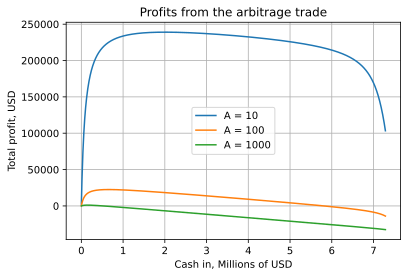

In [96]:
%config InlineBackend.figure_format = 'svg'
#Arbitrage Step
profits = np.array([])
As = np.array([10, 100, 1000])
tokens_in = np.zeros(3)
tokens_out = np.zeros(3)
ttBs = np.zeros(3)
ttSs = np.zeros(3)
psps = []
msps = []
for i in range(0, len(As)):
    psp, msp, token_in, token_out, cash_in, cash_out, profit, ttB, ttS, mPI = arbitrageStep(int(As[i]), pool_f, prices[0], max(pool_f))
    plt.plot(cash_in/1e6, profit)
    tokens_in[i] = token_in[mPI]
    tokens_out[i] = token_in[mPI]
    ttBs[i] = ttB
    ttSs[i] = ttS
    psps.append(psp)
    msps.append(msp)
a = plt.legend(['A = ' + str(int(i)) for i in As])
plt.grid()
plt.title('Profits from the arbitrage trade')
plt.xlabel('Cash in, Millions of USD')
plt.ylabel('Total profit, USD')

## Obvious things
As it should be understandable, coefficient A gradually adjusts the AMM invariant from constant product ($A -> 0$) to constant sum ($A -> \infty$).
We can derive from the plot that arbitrage trades are larger with lesser A (e.g. the invariant is closer to constant product), which is expectable.
Also we should note the shape of the profits curve. The profits keep rising until the amount of trade is large enough for price slippage to kick in. 
Let's now look at the pool, assuming that the most profitable trade was executed for each A.

In [98]:
pools = np.zeros((3, 4))
print('Initial pool:')
print(pool_f)
print('\nPool after trade:')
for i in range(0, len(As)):
    pool = copy.deepcopy(pool_f)
    for k in range(0, len(pool_f)):
        if (k == ttB):
            pool[k] += tokens_in[i]
        if (k == ttS):
            pool[k] -= tokens_out[i]
    pool = [float(p) for p in pool]
    pool = np.array(pool)
    print('A = ' + str(int(As[i])))
    print(pool)
    pools[i] = pool

Initial pool:
[7284941, 2255165, 87581, 365654]

Pool after trade:
A = 10
[5308126.09895165 2255165.         2064395.90104835  365654.        ]
A = 100
[6637331.81728331 2255165.          735190.18271669  365654.        ]
A = 1000
[7140274.52151691 2255165.          232247.47848309  365654.        ]


Now let's explore spot prices changes and compare them to the previous market prices:

In [124]:
for k in range(0, len(pools)):
    print('\nA = ' + str(int(As[k])))
    pool = copy.deepcopy(pools[k])
    n = len(pool)
    
    poolSpotPrices = np.zeros((n, n))
    marketSpotPrices = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            poolSpotPrices[i][j] = calcSpotPrice(A, pool, i, j)
            marketSpotPrices[i][j] = calcMarketPrice(prices[0], i, j)
            
            
    
    print('Pool spot prices:\n============\n')
    print('Initial:')
    print(psps[k])
    print('After trade:')
    print(poolSpotPrices)
    print('\n\n')
    print('Pool spot prices difference:\n============\n')
    pspd = poolSpotPrices - psps[k]
    print(pspd)
    print('New pool and market spot prices difference:\n============\n')
    pmspd = poolSpotPrices[k] - marketSpotPrices
    print(pmspd)
    print('Max pool-market spot price difference: ' + str(max(pmspd[k])))
    print('\n\n')


A = 10
Pool spot prices:

Initial:
[[1.         1.07530649 3.77478904 1.63893108]
 [0.92996749 1.         3.51042873 1.52415238]
 [0.26491819 0.28486823 1.         0.43418248]
 [0.6101548  0.65610337 2.30320021 1.        ]]
After trade:
[[1.         1.00004292 1.00004982 1.00042853]
 [0.99995708 1.         1.0000069  1.0003856 ]
 [0.99995019 0.9999931  1.         1.0003787 ]
 [0.99957166 0.99961456 0.99962145 1.        ]]



Pool spot prices difference:

[[-9.31322575e-10 -7.52635682e-02 -2.77473922e+00 -6.38502550e-01]
 [ 6.99895970e-02 -1.86264515e-09 -2.51042183e+00 -5.23766779e-01]
 [ 7.35031997e-01  7.15124871e-01 -2.03726813e-10  5.66196222e-01]
 [ 3.89416851e-01  3.43511183e-01 -1.30357876e+00  1.16415322e-10]]
New pool and market spot prices difference:

[[ 9.31322575e-10  3.59651108e-03  2.54051756e-02  2.52076314e-02]
 [-3.56626413e-03  4.29190695e-05  2.19293345e-02  2.17297352e-02]
 [-2.60149774e-02 -2.23260206e-02  4.98164445e-05 -1.62719120e-04]
 [-2.54087050e-02 -2.1721

As we can see, with large coefficient ($A = 1000$) spot price difference between the pool and the market becomes more negligeble, while SPD for $A = 10$ didn't change at all, and for $A = 100$ it changed a little.

## Conclusions:

It it somewhat understandable that arbitrage possibilities depend on difference of market and pool states.
If the pool has spot prices close to $1$ and the coefficient is set accordingly ($A$ is big and the invariant is closer to constant sum), and at the same time market spot prices differ a lot, there is a potential for huge arbitrage deals. Vice versa, if the pool contains diffrently spot priced tokens ($A$ is low and the ivariant is closer to constant product), but the market prices of the tokens are close, arbitrageurs have an ability to trade manipulating with pool spot prices.

That said, if we apply a Curve invariant pool to the tokens that are volatile and their prices may differ significantly, the coefficient should be adjusted non-stop to account for the spot price difference.

## P.S.
I concider iterating through prices list not informative, as this won't show any valuable data because in the test model there is no correlation between market prices and pool prices, which we should account for.